In [1]:
import os
from PIL import Image
import json
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
from transformers import ViTFeatureExtractor, ViTForImageClassification
from functools import partial
import shutil
import time


def write_to_txt(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)

def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset


current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]

for dataset_path in dataset_paths:

    dataset = load_images_from_directory(dataset_path)

    # Load ImageNet class index
    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    # Initialize the ViT model
    model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384').to(device)
    model.eval()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.Resize((384, 384)), # Adjust size for ViT
        transforms.ToTensor(),
        normalize
    ])

    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

    true_labels = []
    predicted_labels = []

    # Create the target directory if it does not exist
    target_dir = dataset_path + "_vit"
    os.makedirs(target_dir, exist_ok=True)
    start_time = time.time()
    for img, label, filename in tqdm(dataset):
        img = ensure_rgb(img)  
        img_tensor = transform(img).to(device)
        
        # Model prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0)).logits
            predicted_label = torch.argmax(logits, dim=1).item()
        
        # Get true label
        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        # If prediction is correct, copy the image to the target directory
        # if true_label == predicted_label:
        #     source_path = os.path.join(dataset_path, label + "_" + filename, 'original.jpg')
        #     target_label_dir = os.path.join(target_dir, label)
        #     os.makedirs(target_label_dir, exist_ok=True)  # Make sure the directory exists
        #     shutil.copy(source_path, target_label_dir)  # Copy the file

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    end_time = time.time()
    prediction_time = end_time - start_time
    print(f"Total Prediction Time: {prediction_time:.2f} seconds")


    results = []

    results.append(f"Precision: {precision:.4f}\n")
    results.append(f"Recall: {recall:.4f}\n")
    results.append(f"F1 Score: {f1:.4f}\n")
    results.append(f"Total Prediction Time: {prediction_time:.2f} seconds\n")
    results.append("\n")

    for target_class in set(true_labels):
        # Use sklearn's confusion matrix
        matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
        if matrix.size == 1:
            value = matrix[0][0]
            if target_class in predicted_labels:  # It was predicted at least once
                tp = value
                tn, fp, fn = 0, 0, 0
            else:  # It was never predicted
                tn = value
                tp, fp, fn = 0, 0, 0
        else:
            tn, fp, fn, tp = matrix.ravel()
        results.append(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}\n")
        print(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")



    dataset_name = os.path.basename(dataset_path)
    model_name = "vit-large"
    # Prepare the metrics filename with the model name and dataset name
    metrics_filename = f"{model_name}_{dataset_name}.txt"
    metrics_path = os.path.join(os.path.dirname(dataset_path), metrics_filename)
    with open(metrics_path, "w") as f:
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")

        for target_class in sorted(set(true_labels)):
            matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
            if matrix.size == 1:
                value = matrix[0][0]
                if target_class in predicted_labels:  # It was predicted at least once
                    tp = value
                    tn, fp, fn = 0, 0, 0
                else:  # It was never predicted
                    tn = value
                    tp, fp, fn = 0, 0, 0
            else:
                tn, fp, fn, tp = matrix.ravel() if matrix.size == 4 else (0, 0, 0, matrix[0][0])
            # Now we append the confusion matrix for each class to the file
            f.write(f"Class {target_class} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}\n")

    print(f"Metrics saved to {metrics_path}")


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10000/10000 [02:11<00:00, 75.83it/s]


Precision: 0.7393
Recall: 0.7071
F1 Score: 0.7065
Total Prediction Time: 131.88 seconds
For class 0: TP=9, FP=0, FN=0, TN=0
For class 1: TP=10, FP=0, FN=0, TN=0
For class 2: TP=7, FP=0, FN=0, TN=0
For class 3: TP=6, FP=0, FN=0, TN=0
For class 4: TP=7, FP=0, FN=0, TN=0
For class 5: TP=6, FP=0, FN=0, TN=0
For class 6: TP=5, FP=0, FN=0, TN=0
For class 7: TP=6, FP=0, FN=0, TN=0
For class 8: TP=9, FP=0, FN=0, TN=0
For class 9: TP=10, FP=0, FN=0, TN=0
For class 10: TP=9, FP=0, FN=0, TN=0
For class 11: TP=9, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=10, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=10, FP=0, FN=0, TN=0
For class 16: TP=9, FP=0, FN=0, TN=0
For class 17: TP=9, FP=0, FN=0, TN=0
For class 18: TP=8, FP=0, FN=0, TN=0
For class 19: TP=10, FP=0, FN=0, TN=0
For class 20: TP=7, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=10, FP=0, FN=0, TN=0
For class 24: TP=10, FP=0,

100%|██████████| 10000/10000 [02:13<00:00, 74.78it/s]


Precision: 0.6911
Recall: 0.6419
F1 Score: 0.6410
Total Prediction Time: 133.73 seconds
For class 0: TP=8, FP=0, FN=0, TN=0
For class 1: TP=7, FP=0, FN=0, TN=0
For class 2: TP=9, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=6, FP=0, FN=0, TN=0
For class 6: TP=6, FP=0, FN=0, TN=0
For class 7: TP=6, FP=0, FN=0, TN=0
For class 8: TP=9, FP=0, FN=0, TN=0
For class 9: TP=10, FP=0, FN=0, TN=0
For class 10: TP=8, FP=0, FN=0, TN=0
For class 11: TP=9, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=10, FP=0, FN=0, TN=0
For class 14: TP=9, FP=0, FN=0, TN=0
For class 15: TP=10, FP=0, FN=0, TN=0
For class 16: TP=7, FP=0, FN=0, TN=0
For class 17: TP=9, FP=0, FN=0, TN=0
For class 18: TP=8, FP=0, FN=0, TN=0
For class 19: TP=10, FP=0, FN=0, TN=0
For class 20: TP=8, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=10, FP=0, FN=0, TN=0
For class 24: TP=10, FP=0, 

100%|██████████| 10000/10000 [02:15<00:00, 73.83it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5967
Recall: 0.4920
F1 Score: 0.4980
Total Prediction Time: 135.45 seconds
For class 0: TP=6, FP=0, FN=0, TN=0
For class 1: TP=6, FP=0, FN=0, TN=0
For class 2: TP=6, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=5, FP=0, FN=0, TN=0
For class 6: TP=3, FP=0, FN=0, TN=0
For class 7: TP=6, FP=0, FN=0, TN=0
For class 8: TP=8, FP=0, FN=0, TN=0
For class 9: TP=9, FP=0, FN=0, TN=0
For class 10: TP=7, FP=0, FN=0, TN=0
For class 11: TP=8, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=9, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=8, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=9, FP=0, FN=0, TN=0
For class 18: TP=8, FP=0, FN=0, TN=0
For class 19: TP=6, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=6, FP=0, FN=0, TN=0
For class 22: TP=9, FP=0, FN=0, TN=0
For class 23: TP=8, FP=0, FN=0, TN=0
For class 24: TP=7, FP=0, FN=0, T

100%|██████████| 10000/10000 [02:13<00:00, 75.10it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.7010
Recall: 0.6617
F1 Score: 0.6594
Total Prediction Time: 133.17 seconds
For class 0: TP=9, FP=0, FN=0, TN=0
For class 1: TP=9, FP=0, FN=0, TN=0
For class 2: TP=8, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=7, FP=0, FN=0, TN=0
For class 5: TP=8, FP=0, FN=0, TN=0
For class 6: TP=2, FP=0, FN=0, TN=0
For class 7: TP=6, FP=0, FN=0, TN=0
For class 8: TP=9, FP=0, FN=0, TN=0
For class 9: TP=8, FP=0, FN=0, TN=0
For class 10: TP=10, FP=0, FN=0, TN=0
For class 11: TP=4, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=7, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=9, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=8, FP=0, FN=0, TN=0
For class 18: TP=6, FP=0, FN=0, TN=0
For class 19: TP=7, FP=0, FN=0, TN=0
For class 20: TP=7, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=9, FP=0, FN=0, TN=0
For class 24: TP=10, FP=0, FN=0

100%|██████████| 10000/10000 [02:13<00:00, 75.11it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.6660
Recall: 0.6152
F1 Score: 0.6128
Total Prediction Time: 133.15 seconds
For class 0: TP=8, FP=0, FN=0, TN=0
For class 1: TP=9, FP=0, FN=0, TN=0
For class 2: TP=7, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=6, FP=0, FN=0, TN=0
For class 5: TP=8, FP=0, FN=0, TN=0
For class 6: TP=2, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=8, FP=0, FN=0, TN=0
For class 9: TP=9, FP=0, FN=0, TN=0
For class 10: TP=9, FP=0, FN=0, TN=0
For class 11: TP=4, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=7, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=9, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=8, FP=0, FN=0, TN=0
For class 18: TP=5, FP=0, FN=0, TN=0
For class 19: TP=7, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=9, FP=0, FN=0, TN=0
For class 24: TP=10, FP=0, FN=0,

100%|██████████| 10000/10000 [02:13<00:00, 74.93it/s]
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5961
Recall: 0.5053
F1 Score: 0.5075
Total Prediction Time: 133.48 seconds
For class 0: TP=8, FP=0, FN=0, TN=0
For class 1: TP=6, FP=0, FN=0, TN=0
For class 2: TP=3, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=4, FP=0, FN=0, TN=0
For class 5: TP=6, FP=0, FN=0, TN=0
For class 6: TP=1, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=6, FP=0, FN=0, TN=0
For class 9: TP=8, FP=0, FN=0, TN=0
For class 10: TP=8, FP=0, FN=0, TN=0
For class 11: TP=2, FP=0, FN=0, TN=0
For class 12: TP=8, FP=0, FN=0, TN=0
For class 13: TP=5, FP=0, FN=0, TN=0
For class 14: TP=7, FP=0, FN=0, TN=0
For class 15: TP=9, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=9, FP=0, FN=0, TN=0
For class 18: TP=3, FP=0, FN=0, TN=0
For class 19: TP=4, FP=0, FN=0, TN=0
For class 20: TP=6, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=6, FP=0, FN=0, TN=0
For class 24: TP=9, FP=0, FN=0, T

100%|██████████| 10000/10000 [02:09<00:00, 77.03it/s]


Precision: 0.7647
Recall: 0.7415
F1 Score: 0.7405
Total Prediction Time: 129.84 seconds
For class 0: TP=9, FP=0, FN=0, TN=0
For class 1: TP=9, FP=0, FN=0, TN=0
For class 2: TP=10, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=9, FP=0, FN=0, TN=0
For class 5: TP=7, FP=0, FN=0, TN=0
For class 6: TP=6, FP=0, FN=0, TN=0
For class 7: TP=5, FP=0, FN=0, TN=0
For class 8: TP=9, FP=0, FN=0, TN=0
For class 9: TP=10, FP=0, FN=0, TN=0
For class 10: TP=10, FP=0, FN=0, TN=0
For class 11: TP=8, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=10, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=10, FP=0, FN=0, TN=0
For class 16: TP=9, FP=0, FN=0, TN=0
For class 17: TP=10, FP=0, FN=0, TN=0
For class 18: TP=8, FP=0, FN=0, TN=0
For class 19: TP=10, FP=0, FN=0, TN=0
For class 20: TP=9, FP=0, FN=0, TN=0
For class 21: TP=8, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=10, FP=0, FN=0, TN=0
For class 24: TP=10, FP=

100%|██████████| 10000/10000 [02:15<00:00, 73.96it/s]


Precision: 0.7627
Recall: 0.7392
F1 Score: 0.7383
Total Prediction Time: 135.21 seconds
For class 0: TP=9, FP=0, FN=0, TN=0
For class 1: TP=9, FP=0, FN=0, TN=0
For class 2: TP=9, FP=0, FN=0, TN=0
For class 3: TP=6, FP=0, FN=0, TN=0
For class 4: TP=8, FP=0, FN=0, TN=0
For class 5: TP=7, FP=0, FN=0, TN=0
For class 6: TP=6, FP=0, FN=0, TN=0
For class 7: TP=7, FP=0, FN=0, TN=0
For class 8: TP=9, FP=0, FN=0, TN=0
For class 9: TP=9, FP=0, FN=0, TN=0
For class 10: TP=10, FP=0, FN=0, TN=0
For class 11: TP=8, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=10, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=10, FP=0, FN=0, TN=0
For class 16: TP=9, FP=0, FN=0, TN=0
For class 17: TP=10, FP=0, FN=0, TN=0
For class 18: TP=8, FP=0, FN=0, TN=0
For class 19: TP=10, FP=0, FN=0, TN=0
For class 20: TP=9, FP=0, FN=0, TN=0
For class 21: TP=8, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=10, FP=0, FN=0, TN=0
For class 24: TP=10, FP=0,

100%|██████████| 10000/10000 [02:13<00:00, 74.89it/s]


Precision: 0.7300
Recall: 0.7004
F1 Score: 0.6987
Total Prediction Time: 133.56 seconds
For class 0: TP=9, FP=0, FN=0, TN=0
For class 1: TP=10, FP=0, FN=0, TN=0
For class 2: TP=9, FP=0, FN=0, TN=0
For class 3: TP=5, FP=0, FN=0, TN=0
For class 4: TP=8, FP=0, FN=0, TN=0
For class 5: TP=7, FP=0, FN=0, TN=0
For class 6: TP=5, FP=0, FN=0, TN=0
For class 7: TP=6, FP=0, FN=0, TN=0
For class 8: TP=9, FP=0, FN=0, TN=0
For class 9: TP=9, FP=0, FN=0, TN=0
For class 10: TP=10, FP=0, FN=0, TN=0
For class 11: TP=9, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=10, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=10, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=10, FP=0, FN=0, TN=0
For class 18: TP=6, FP=0, FN=0, TN=0
For class 19: TP=9, FP=0, FN=0, TN=0
For class 20: TP=7, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=10, FP=0, FN=0, TN=0
For class 24: TP=10, FP=0,

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[codecarbon INFO @ 12:29:33] [setup] RAM Tracking...
[codecarbon INFO @ 12:29:33] [setup] GPU Tracking...
[codecarbon INFO @ 12:29:33] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:29:33] [setup] CPU Tracking...
[codecarbon WARNING @ 12:29:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:29:34] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 12:29:34] >>> Tracker's metadata:
[codecarbon INFO @ 12:29:34]   Platform system: Linux-6.2.0-36-generic-x86_64-with-glibc2.17
[codecarbon INFO @ 12:29:34]   Python version: 3.8.18
[codecarbon INFO @ 12:29:34]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 12:29:34]   Available RAM : 31.242 GB
[

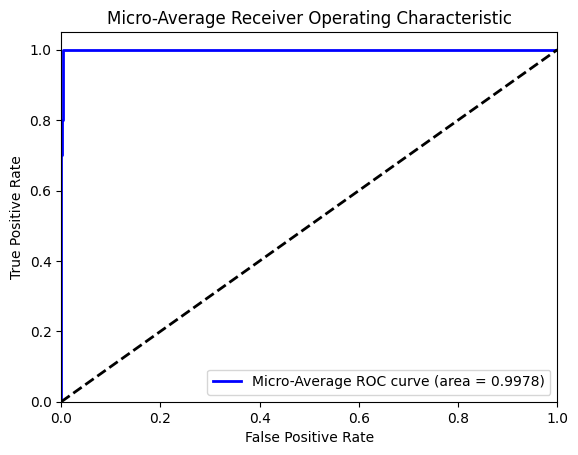

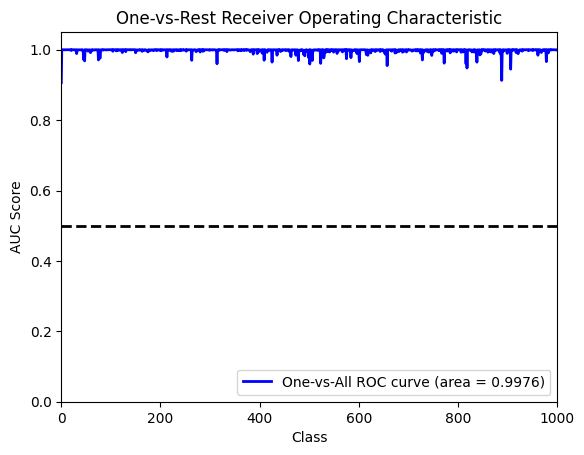

[codecarbon INFO @ 12:32:45] Energy consumed for RAM : 0.000612 kWh. RAM Power : 11.715703010559082 W
[codecarbon INFO @ 12:32:45] Energy consumed for all GPUs : 0.009476 kWh. Total GPU Power : 109.51365105871311 W
[codecarbon INFO @ 12:32:45] Energy consumed for all CPUs : 0.002482 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 12:32:45] 0.012571 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:32:45] Already started tracking


Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_vit/vit_val_images10k_metrics.txt


100%|██████████| 10000/10000 [02:37<00:00, 63.47it/s]


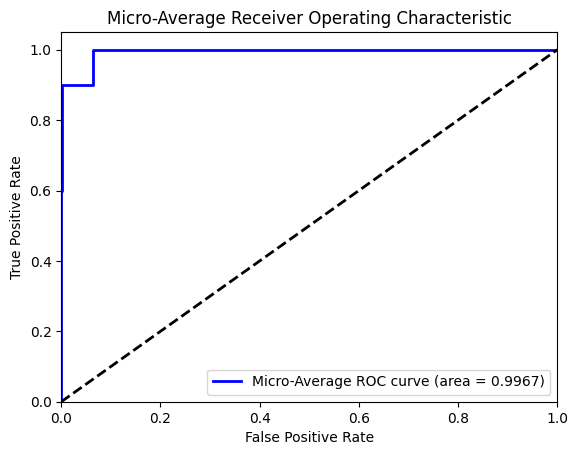

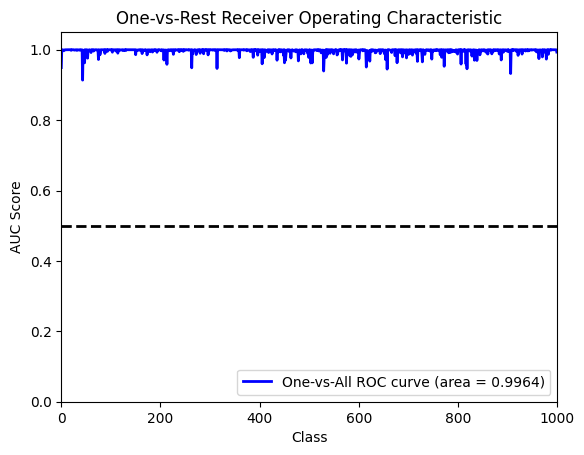

[codecarbon WARNING @ 12:35:34] Tracker already stopped !
[codecarbon WARNING @ 12:35:34] Background scheduler didn't run for a long period (168s), results might be inaccurate
[codecarbon INFO @ 12:35:34] Energy consumed for RAM : 0.001161 kWh. RAM Power : 11.715703010559082 W
[codecarbon INFO @ 12:35:34] Energy consumed for all GPUs : 0.018444 kWh. Total GPU Power : 191.41438759625424 W
[codecarbon INFO @ 12:35:34] Energy consumed for all CPUs : 0.004708 kWh. Total CPU Power : 47.5 W
[codecarbon INFO @ 12:35:34] 0.024312 kWh of electricity used since the beginning.
[codecarbon WARNING @ 12:35:34] Already started tracking


K-S statistic for 1: 0.06280
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/gaussian_noise/1_vit/vit_1_metrics.txt


 49%|████▉     | 4933/10000 [01:13<01:16, 66.19it/s]

In [1]:
import os
from PIL import Image
import json
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
from transformers import ViTFeatureExtractor, ViTForImageClassification
from functools import partial
import shutil
import time
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import json
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from scipy.stats import ks_2samp

def write_to_txt(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)

def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset
def calculate_ks_statistic(distribution1, distribution2):
    ks_statistic, p_value = ks_2samp(distribution1, distribution2)
    return ks_statistic

current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]

original_dataset_probs = None

from codecarbon import EmissionsTracker

tracker = EmissionsTracker()


for dataset_path in dataset_paths:
    tracker.start()

    dataset = load_images_from_directory(dataset_path)

    # Load ImageNet class index
    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    # Initialize the ViT model
    model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384').to(device)
    model.eval()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.Resize((384, 384)), # Adjust size for ViT
        transforms.ToTensor(),
        normalize
    ])

    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

    predicted_probs = []
    true_labels = []
    predicted_labels = []

    # Create the target directory if it does not exist
    target_dir = dataset_path + "_vit"
    os.makedirs(target_dir, exist_ok=True)
    num_classes = 1000

    start_time = time.time()
    for img, label, filename in tqdm(dataset):
        img = ensure_rgb(img)  
        img_tensor = transform(img).to(device)
        
        # Model prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0)).logits
            predicted_label = torch.argmax(logits, dim=1).item()
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
        # Get true label
        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_probs.append(probabilities)
        predicted_label = np.argmax(probabilities)
        predicted_labels.append(predicted_label)
        # If prediction is correct, copy the image to the target directory
        # if true_label == predicted_label:
        #     source_path = os.path.join(dataset_path, label + "_" + filename, 'original.jpg')
        #     target_label_dir = os.path.join(target_dir, label)
        #     os.makedirs(target_label_dir, exist_ok=True)  # Make sure the directory exists
        #     shutil.copy(source_path, target_label_dir)  # Copy the file


    true_labels_binary = label_binarize(true_labels, classes=range(num_classes))
    predicted_probs = np.array(predicted_probs)

    fpr, tpr, _ = roc_curve(true_labels_binary.ravel(), predicted_probs.ravel())
    roc_auc = auc(fpr, tpr)

    class_auc_scores = []
    for i in range(num_classes):
        true_binary = (np.array(true_labels) == i).astype(int)
        pred_probs = predicted_probs[:, i]
        fpr, tpr, _ = roc_curve(true_binary, pred_probs)
        auc_score = auc(fpr, tpr)
        class_auc_scores.append(auc_score)
    roc_auc_one_vs_rest = np.mean(class_auc_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-Average ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(target_dir, f"{os.path.basename(dataset_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.show()
    plt.figure()
    plt.plot(range(num_classes), class_auc_scores, color='blue', lw=2, label='One-vs-All ROC curve (area = {0:0.4f})'.format(roc_auc_one_vs_rest))
    plt.plot([0, num_classes], [0.5, 0.5], 'k--', lw=2)
    plt.xlim([0, num_classes])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Class')
    plt.ylabel('AUC Score')
    plt.title('One-vs-Rest Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(target_dir, f"{os.path.basename(dataset_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.show()



    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
    cm = confusion_matrix(true_labels, predicted_labels)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)




    dataset_name = os.path.basename(dataset_path)
    model_name = "vit"
    metrics_filename = f"{model_name}_{dataset_name}_metrics.txt"
    metrics_path = os.path.join(target_dir, metrics_filename)


    if dataset_path == dataset_paths[0]:
        original_dataset_probs = [max(probs) for probs in predicted_probs]  # 选择最高的概率值
    else:
        # 对于攻击数据集
        attacked_dataset_probs = [max(probs) for probs in predicted_probs]
        ks_statistic = calculate_ks_statistic(original_dataset_probs, attacked_dataset_probs)
        print(f"K-S statistic for {os.path.basename(dataset_path)}: {ks_statistic:.5f}")

        # 将K-S值写入度量文件
        with open(metrics_path, "a") as f:
            f.write(f"K-S Statistic (vs original): {ks_statistic:.5f}\n")
            
    with open(metrics_path, "w") as f:
        f.write(f"Micro-Average AUC: {roc_auc:.5f}\n")
        f.write(f"One-vs-rest Average AUC: {roc_auc_one_vs_rest:.5f}\n")
        f.write(f"Precision (micro-average): {precision:.5f}\n")
        f.write(f"Recall (micro-average): {recall:.5f}\n")
        f.write(f"F1 Score (micro-average): {f1_score:.5f}\n")
        f.write(f"True Positives (per class): {tp.tolist()}\n")
        f.write(f"False Positives (per class): {fp.tolist()}\n")
        f.write(f"False Negatives (per class): {fn.tolist()}\n")
        f.write(f"True Negatives (per class): {tn.tolist()}\n")

    print(f"Metrics saved to {metrics_path}")
    tracker.stop()



In [2]:
# import os
# from PIL import Image
# import json
# from torchvision import transforms
# import torch
# from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
# from tqdm import tqdm
# from transformers import ViTFeatureExtractor, ViTForImageClassification
# from functools import partial
# import shutil
# import time


# def write_to_txt(filepath, content):
#     with open(filepath, "w") as file:
#         file.write(content)

# def load_images_from_directory(root_path: str):
#     dataset = []
#     for label_folder in os.listdir(root_path):
#         image_id, image_label = label_folder.rsplit('_', 1)  # Split from the last underscore to get image label
#         image_path = os.path.join(root_path, label_folder, 'masked_image.jpg')
#         if os.path.exists(image_path):
#             img = Image.open(image_path)
#             dataset.append((img, image_label, image_id))
#     return dataset




# current_dir = "/home/z/Music/code/CAIN"
# dataset_path = f"{current_dir}/imagenet/val_images10k"
# #dataset_path = f"{current_dir}/results/imagenet/val_images10k_attack/defocus_blur/2_vit/google/vit-large-patch32-384/HiResCAM"

# dataset = load_images_from_directory(dataset_path)

# # Load ImageNet class index
# with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
#     imagenet_class_index = json.load(f)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

# # Initialize the ViT model
# model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384').to(device)
# model.eval()

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# transform = transforms.Compose([
#     transforms.Resize((384, 384)), # Adjust size for ViT
#     transforms.ToTensor(),
#     normalize
# ])

# def ensure_rgb(img):
#     if img.mode != 'RGB':
#         return img.convert('RGB')
#     return img

# true_labels = []
# predicted_labels = []

# # Create the target directory if it does not exist
# target_dir = dataset_path + "_vit"
# os.makedirs(target_dir, exist_ok=True)
# start_time = time.time()
# for img, label, filename in tqdm(dataset):
#     img = ensure_rgb(img)  
#     img_tensor = transform(img).to(device)
    
#     # Model prediction
#     with torch.no_grad():
#         logits = model(img_tensor.unsqueeze(0)).logits
#         predicted_label = torch.argmax(logits, dim=1).item()
    
#     # Get true label
#     index_str, _ = label_to_index_description.get(label, (None, None))
#     if index_str is None:
#         continue
#     true_label = int(index_str)
#     true_labels.append(true_label)
#     predicted_labels.append(predicted_label)
#     # If prediction is correct, copy the image to the target directory
#     # if true_label == predicted_label:
#     #     source_path = os.path.join(dataset_path, label + "_" + filename, 'original.jpg')
#     #     target_label_dir = os.path.join(target_dir, label)
#     #     os.makedirs(target_label_dir, exist_ok=True)  # Make sure the directory exists
#     #     shutil.copy(source_path, target_label_dir)  # Copy the file

# precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# end_time = time.time()
# prediction_time = end_time - start_time
# print(f"Total Prediction Time: {prediction_time:.2f} seconds")


# results = []

# results.append(f"Precision: {precision:.4f}\n")
# results.append(f"Recall: {recall:.4f}\n")
# results.append(f"F1 Score: {f1:.4f}\n")
# results.append(f"Total Prediction Time: {prediction_time:.2f} seconds\n")
# results.append("\n")

# # for target_class in set(true_labels):
# #     # Use sklearn's confusion matrix
# #     matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
# #     if matrix.size == 1:
# #         value = matrix[0][0]
# #         if target_class in predicted_labels:  # It was predicted at least once
# #             tp = value
# #             tn, fp, fn = 0, 0, 0
# #         else:  # It was never predicted
# #             tn = value
# #             tp, fp, fn = 0, 0, 0
# #     else:
# #         tn, fp, fn, tp = matrix.ravel()
# #     results.append(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}\n")
# #     print(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")



# # results_path = os.path.join(target_dir, "results.txt")
# # write_to_txt(results_path, ''.join(results))

